**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Ripper Classifier

We import the libraries and define constants and settings of the notebook:

In [1]:
import pandas as pd
import json
import pickle
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, f1_score
from time import time
from classification_utils import *

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RESULTS_DIR = '../data/classification_results'
RANDOM_STATE = 42
clf_name = 'RipperClassifier'

We load the data:

In [2]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_rule_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use:

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day', 'day_of_week', 'month', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 31


We define a list of the categorical features:

In [4]:
categorical_features = [
    'day', 'day_of_week', 'month', 'year',
    'democrat', 'gun_law_rank',
    'aggression', 'accidental', 'defensive', 'suicide',
    'road', 'house', 'school', 'business',
    'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction'
]

We perform a grid search:

In [5]:
ripper = lw.RIPPER()
param_grid = {
    'prune_size':[0.33, 0.5], # the fraction of rules to prune
    'k': [1, 2]  # the number of optimization runs
}
gs = GridSearchCV(
    estimator=ripper,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=make_scorer(f1_score),
    verbose=10,
    cv=StratifiedShuffleSplit(n_splits=2, test_size=1/3, random_state=RANDOM_STATE),
    refit=True
)
gs.fit(indicators_train_df, true_labels_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START k=1, prune_size=0.33........................................
[CV 1/2; 3/4] START k=2, prune_size=0.33........................................
[CV 2/2; 1/4] START k=1, prune_size=0.33........................................
[CV 1/2; 2/4] START k=1, prune_size=0.5.........................................
[CV 2/2; 2/4] START k=1, prune_size=0.5.........................................
[CV 2/2; 3/4] START k=2, prune_size=0.33........................................
[CV 1/2; 4/4] START k=2, prune_size=0.5.........................................
[CV 2/2; 4/4] START k=2, prune_size=0.5.........................................
[CV 2/2; 1/4] END .........k=1, prune_size=0.33;, score=0.325 total time= 2.2min
[CV 2/2; 4/4] END ..........k=2, prune_size=0.5;, score=0.398 total time= 2.9min
[CV 1/2; 2/4] END ..........k=1, prune_size=0.5;, score=0.389 total time= 3.5min
[CV 2/2; 2/4] END ..........k=1, prune_size=0.5;, 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2, random_state=42,
            test_size=0.3333333333333333, train_size=None),
             estimator=<RIPPER(max_total_conds=None, alpha=1.0, verbosity=0, k=2, prune_size=0.33, random_state=None, dl_allowance=64, max_rules=None, n_discretize_bins=10, max_rule_conds=None)>,
             n_jobs=-1, param_grid={'k': [1, 2], 'prune_size': [0.33, 0.5]},
             scoring=make_scorer(f1_score), verbose=10)

We display the grid search results:

In [6]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_k,param_prune_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,213.110476,84.185562,0.342072,0.059994,1,0.33,"{'k': 1, 'prune_size': 0.33}",0.373734,0.325189,0.349461,0.024273,3
1,215.366538,5.009349,0.358448,0.021536,1,0.5,"{'k': 1, 'prune_size': 0.5}",0.389427,0.374387,0.381907,0.007520,2
2,325.664669,78.719293,0.334608,0.010477,2,0.33,"{'k': 2, 'prune_size': 0.33}",0.362890,0.260877,0.311884,0.051006,4
3,270.231519,95.595936,0.309981,0.011304,2,0.5,"{'k': 2, 'prune_size': 0.5}",0.394026,0.398462,0.396244,0.002218,1


We choose the best model:

In [7]:
best_index = gs.best_index_
ripper = gs.best_estimator_
best_model_params = gs.best_params_
fit_time = gs.refit_time_

We display the extracted rules:

In [8]:
ripper.out_model()

[[suicide=1 ^ gun_law_rank=>12.0 ^ days_from_first_incident=<559.0] V
[suicide=1 ^ n_males_prop=<0.5 ^ age_range=4.0-12.0] V
[gun_law_rank=>12.0 ^ aggression=0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ age_range=>12.0 ^ suicide=1] V
[gun_law_rank=>12.0 ^ aggression=0 ^ democrat=1.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ officers=0 ^ x=784783.45-1282365.91 ^ y=<3404540.76 ^ poverty_perc=13.6-14.5 ^ day_of_week=6] V
[aggression=0 ^ gun_law_rank=>12.0 ^ democrat=1.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ officers=0 ^ x=784783.45-1282365.91 ^ y=<3404540.76 ^ defensive=0 ^ poverty_perc=13.6-14.5 ^ n_males_prop=>0.67 ^ n_child_prop=<0.1] V
[aggression=0 ^ gun_law_rank=>12.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ age_range=>12.0 ^ n_participants=>3.0 ^ n_child_prop=<0.1 ^ democrat=1.0 ^ n_males_prop=>0.67 ^ x=-897668.54-784783.45] V
[aggression=0 ^ gun_law_rank=>12.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ age_range=>12.0 ^ n_participants=>3.0 ^ n_child_prop=<0.1 ^ days_from_first_incident=<559.0

We refit the best model on the whole training set:

In [9]:
# get the predictions on the training data
train_score_start = time()
pred_labels_train = ripper.predict(indicators_train_df)
train_score_time = time()-train_score_start
pred_probas_train = ripper.predict_proba(indicators_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_rules_test = ripper.predict(indicators_test_df,  give_reasons=True)
test_score_time = time()-test_score_start
pred_labels_test = pred_labels_rules_test[0]
pred_rules_test = pred_labels_rules_test[1]
rule_list_str = [str(rule) for rule in pred_rules_test]
pd.DataFrame(rule_list_str).to_csv(f'{RESULTS_DIR}/{clf_name}_rules.csv')
pred_probas_test = ripper.predict_proba(indicators_test_df,  give_reasons=False)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=ripper, file=file)
file.close()

# save the cv results
best_model_cv_results = pd.DataFrame(cv_results_df.iloc[best_index]).T
best_model_cv_results.index = [clf_name]
best_model_cv_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

We display traning and test scores:

In [10]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
RipperClassifier,0.732338,0.95628,0.829459,0.735169,0.257746,0.381678,0.733753,0.607013,0.605569,0.733244,0.732655,0.686109,0.732655,0.60942,702.62222,0.961313,"{'k': 2, 'prune_size': 0.5}"


In [11]:
test_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)
test_scores

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
RipperClassifier,0.729376,0.95364,0.826566,0.716244,0.248527,0.369012,0.72281,0.601083,0.597789,0.725172,0.727917,0.680093,0.727917,0.603319,702.62222,286.96226,"{'k': 2, 'prune_size': 0.5}"


We load the dataset randomly oversampled:

In [12]:
indicators_over_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_over_train_df = indicators_over_train_df[features_for_clf]
true_labels_over_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_10858/2206401294.py:1: DtypeWarning: Columns (11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  indicators_over_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)


We fit and test the best model on the oversampled dataset:

In [13]:
# fit the model on all the training data
best_model_over = lw.RIPPER(**best_model_params)
fit_start = time()
best_model_over.fit(indicators_over_train_df, true_labels_over_train)
fit_over_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_over_train = best_model_over.predict(indicators_over_train_df)
train_score_over_time = time()-train_score_start
pred_probas_over_train = best_model_over.predict_proba(indicators_over_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_over_test = best_model_over.predict(indicators_test_df)
test_score_over_time = time()-test_score_start
pred_probas_over_test = best_model_over.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_over_test, 'probs': pred_probas_over_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversample_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversample.pkl', 'wb')
pickle.dump(obj=best_model_over, file=file)
file.close()

We load the dataset oversampled with SMOTE:

In [14]:
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

We train and test the best model on the SMOTE dataset:

In [15]:
# fit the model on all the training data
best_model_smote = lw.RIPPER(**best_model_params)
fit_start = time()
best_model_smote.fit(indicators_smote_train_df, true_labels_smote_train)
fit_smote_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_df)
train_score_smote_time = time()-train_score_start
pred_probas_smote_train = best_model_smote.predict_proba(indicators_smote_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_df)
test_score_smote_time = time()-test_score_start
pred_probas_smote_test = best_model_smote.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()

We compare the performance of the best model on the three datasets:

In [16]:
test_over_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_over_test,
    train_time=fit_over_time,
    score_time=test_score_over_time,
    params=best_model_params,
    prob_pred=pred_probas_over_test,
    clf_name=clf_name+' over',
    path=f'{RESULTS_DIR}/{clf_name}_over_test_scores.csv'
)

test_smote_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_smote_time,
    score_time=test_score_smote_time,
    params=best_model_params,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name+' SMOTE',
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

pd.concat([test_scores, test_over_scores, test_smote_scores])

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
RipperClassifier,0.729376,0.953640,0.826566,0.716244,0.248527,0.369012,0.722810,0.601083,0.597789,0.725172,0.727917,0.680093,0.727917,0.603319,702.622220,286.962260,"{'k': 2, 'prune_size': 0.5}"
RipperClassifier over,0.773603,0.846547,0.808433,0.592491,0.473841,0.526565,0.683047,0.660194,0.667499,0.715625,0.727236,0.718201,0.727236,0.669843,520.477142,0.453616,"{'k': 2, 'prune_size': 0.5}"
RipperClassifier SMOTE,0.736610,0.941874,0.826691,0.697565,0.284731,0.404396,0.717087,0.613303,0.615543,0.724111,0.731508,0.691505,0.731508,0.616006,1446.875739,0.756599,"{'k': 2, 'prune_size': 0.5}"


We display confusion matrices:

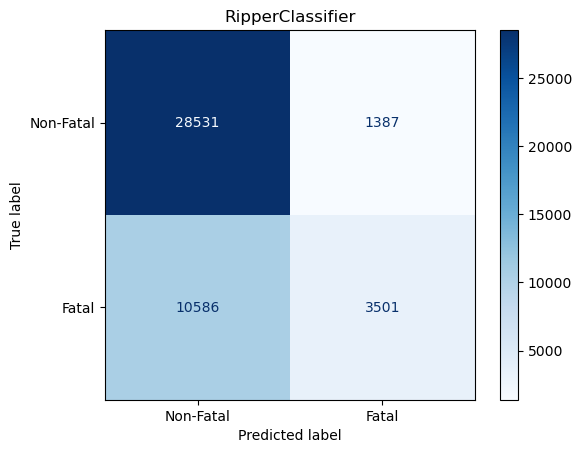

In [17]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name
)

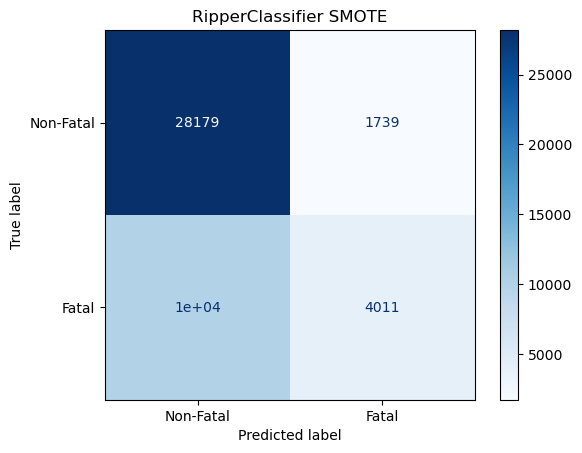

In [18]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name + ' SMOTE'
)

We plot incidents (actual class and predicted class) in different feature spaces:

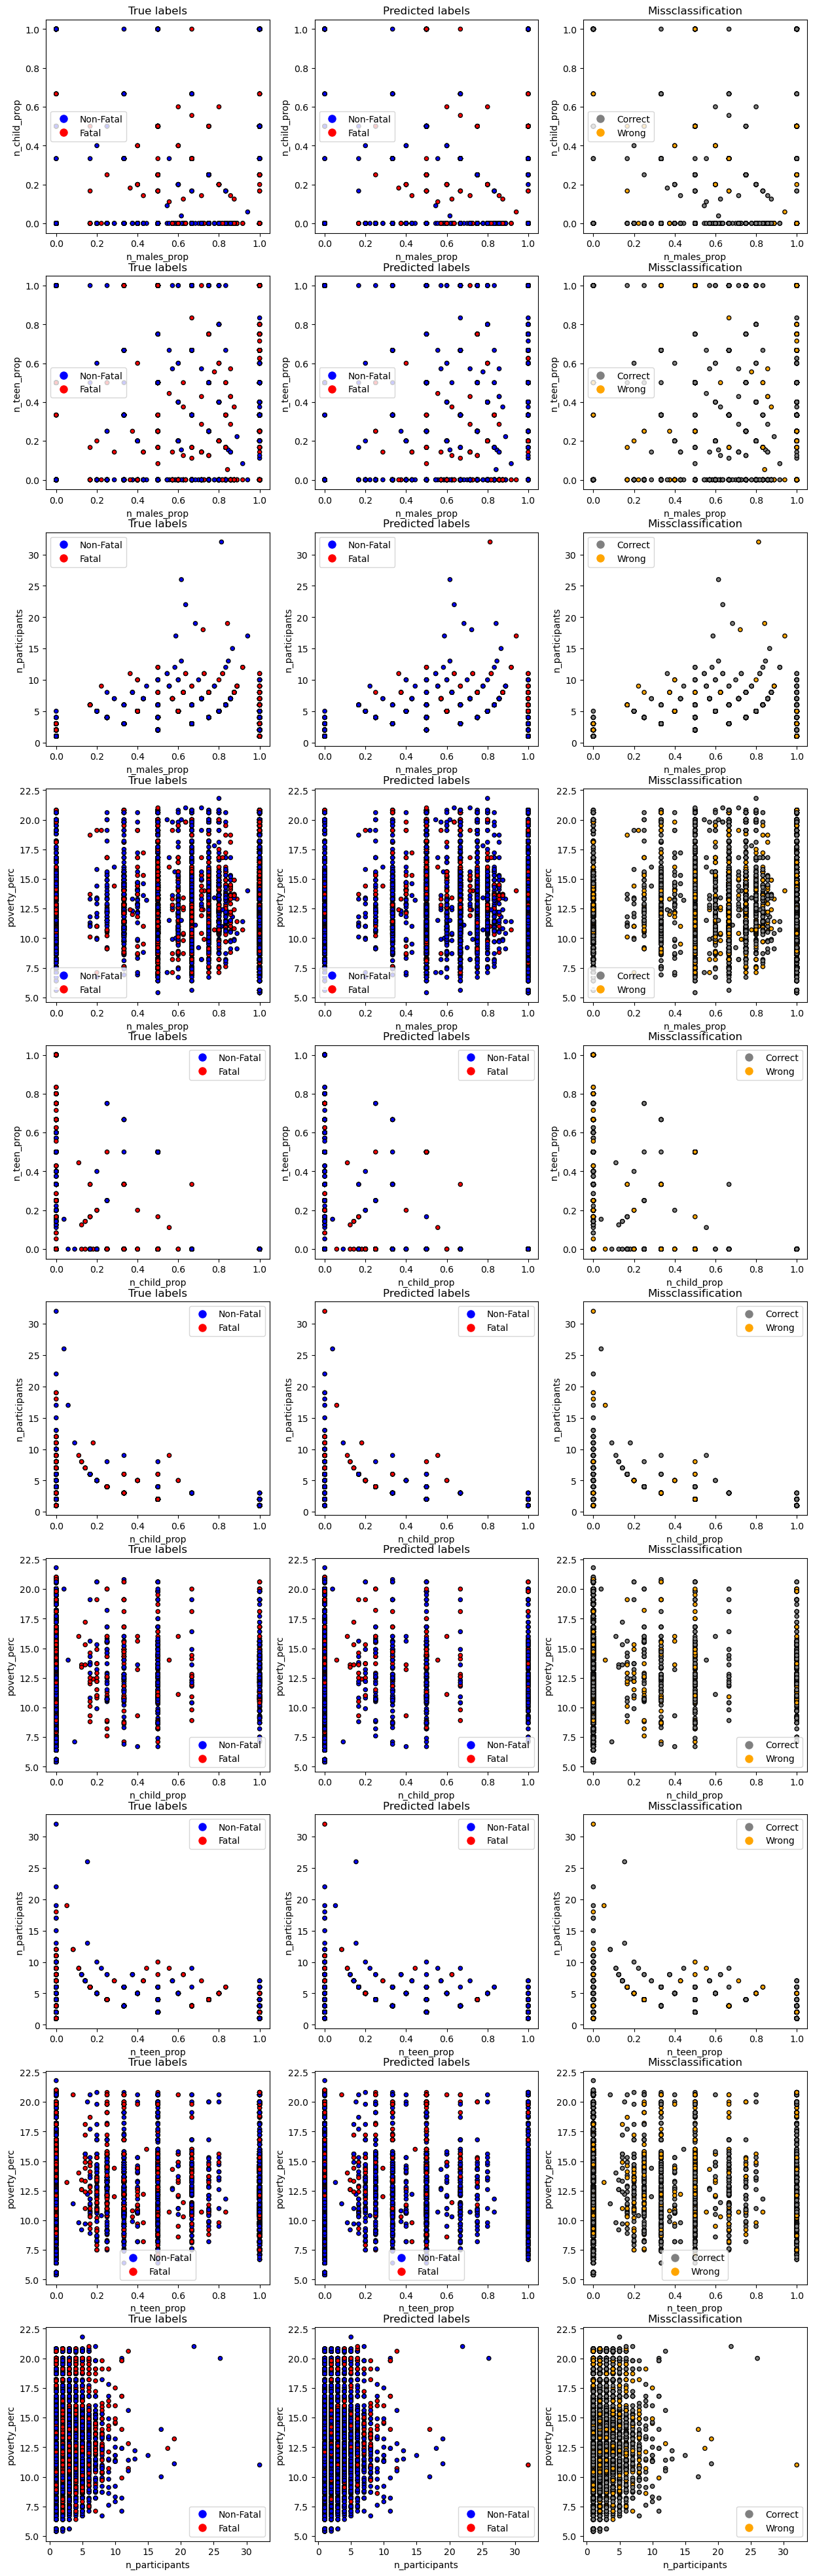

In [19]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['n_males_prop', 'n_child_prop', 'n_teen_prop', 'n_participants', 'poverty_perc'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_test,
    figsize=(15, 50)
)

We plot the ROC curve:

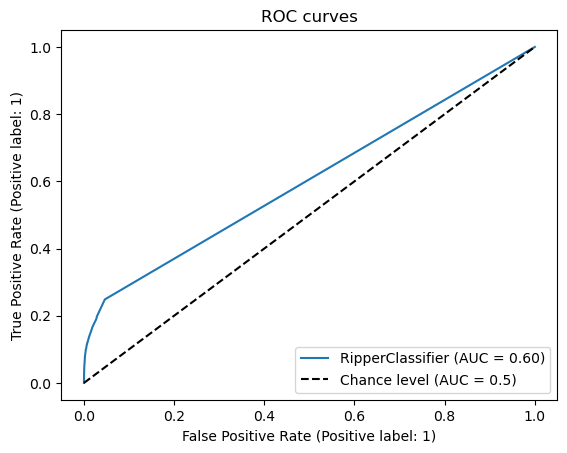

In [20]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_test[:,1]], names=[clf_name])

We plot the distribution of the features for misclassified incidents:

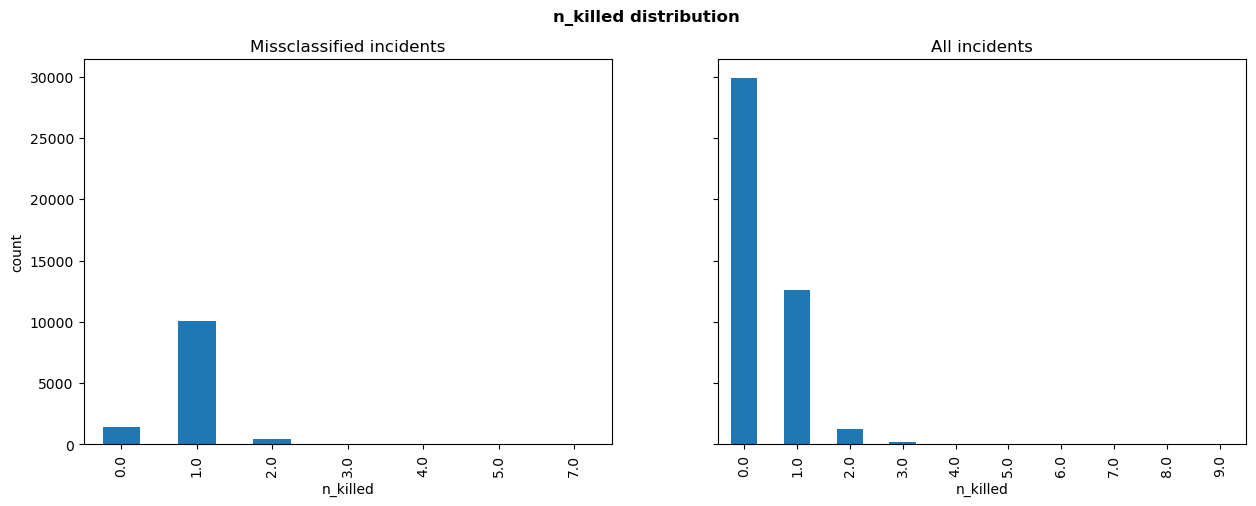

In [21]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

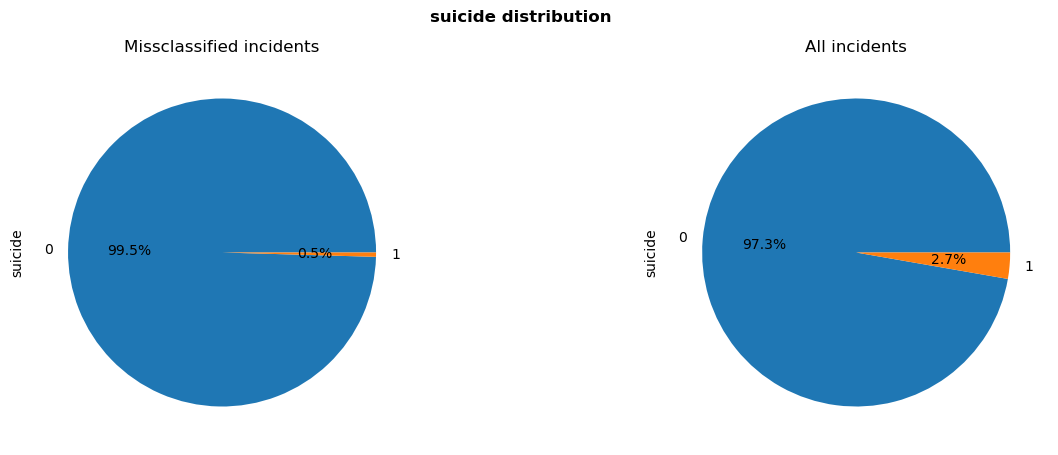

In [22]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

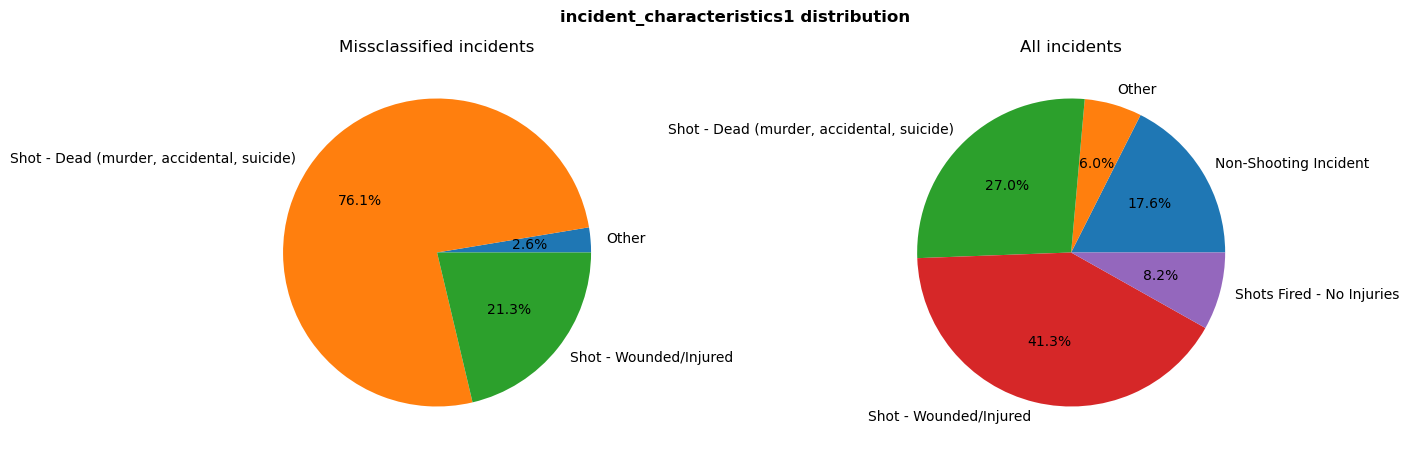

In [23]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie',
    title='incident_characteristics1 distribution'
)

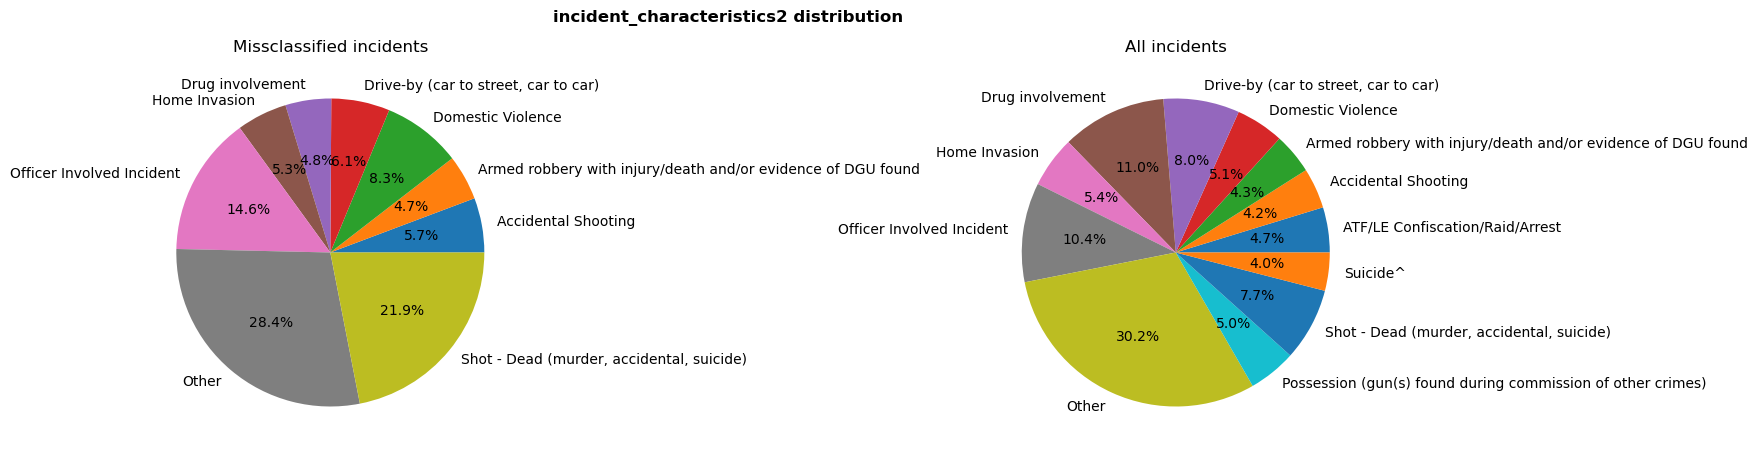

In [24]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='incident_characteristics2 distribution'
)

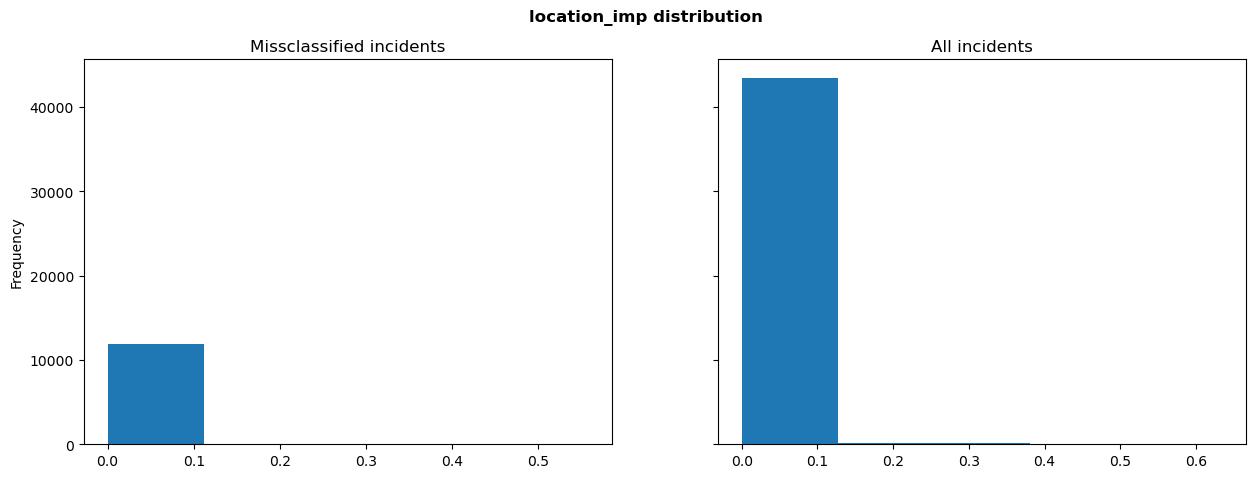

In [25]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)